In [430]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

---

### A bit About dataset:
Dataset Name: **Network Intrusion dataset(CIC-IDS- 2017)** <br>

Its basically a network traffic data set taken from an office at friday afternoon. Attackers ususally start the attack at this time because no one will be in office for next 2.5 days.<br> It has **79 columns** and **2,00,000+ rows**. It is about weather the network traffic is normal or DDOS attack.<br> 

I have taken 2000 rows from the original data set before using it here ( it has total 2,00,000+ rows).<br> wanted to manually check accuracy of the model to simulate user input if its going to be used in web app.

### Dataset Files:
following are the explanations of datasets used here:

- **Raw_Fri_Aft_DDOS.csv** - original data set (not used here) <br>
- **Test_Fri_Aft_DDOS.csv** - 2000 rows from original data set<br>
- **Train_Fri_Aft_DDOS.csv** - Remaining rows from original data set<br>

Every thing else will be explained in the code.

In [431]:
df = pd.read_csv('Train_Fri_Aft_DDOS.csv')
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count',
     

In [432]:
# Remove spaces from column names
# changing label column from string to binary
df.columns = df.columns.str.strip()
df['Label'] = df['Label'].map({'BENIGN': 0, 'DDoS': 1})

In [434]:
# checking for missing values
nan_counts = df.isna().sum()
nan_columns = nan_counts[nan_counts > 0]

# print if some values are missing
for column in nan_columns.index:
    print(f"Column '{column}' has {nan_columns[column]} NaN values.")

In [433]:
# 4 rows had NaN values in the 'Flow Bytes/s' column so I replaced them with the mean of the column
df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(), inplace=True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_32500\2274282452.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Flow Bytes/s'].fillna(df['Flow Bytes/s'].mean(), inplace=True)


### pre-Processing


In [1]:
# ['Flow Bytes/s', 'Flow Packets/s'] both have very large values
# so i will check weather they are useful or not  before drping them
correlation_matrix = df[['Flow Bytes/s', 'Flow Packets/s', 'Label']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


NameError: name 'df' is not defined

The cool color shows that its NOT very dependent on the feature, and the warm color shows that its dependent.<br>
so we can safly drop those columns withoud causing much effect.

I will olso drop some extra columns that are not needed for the model. ( empty or null etc..)

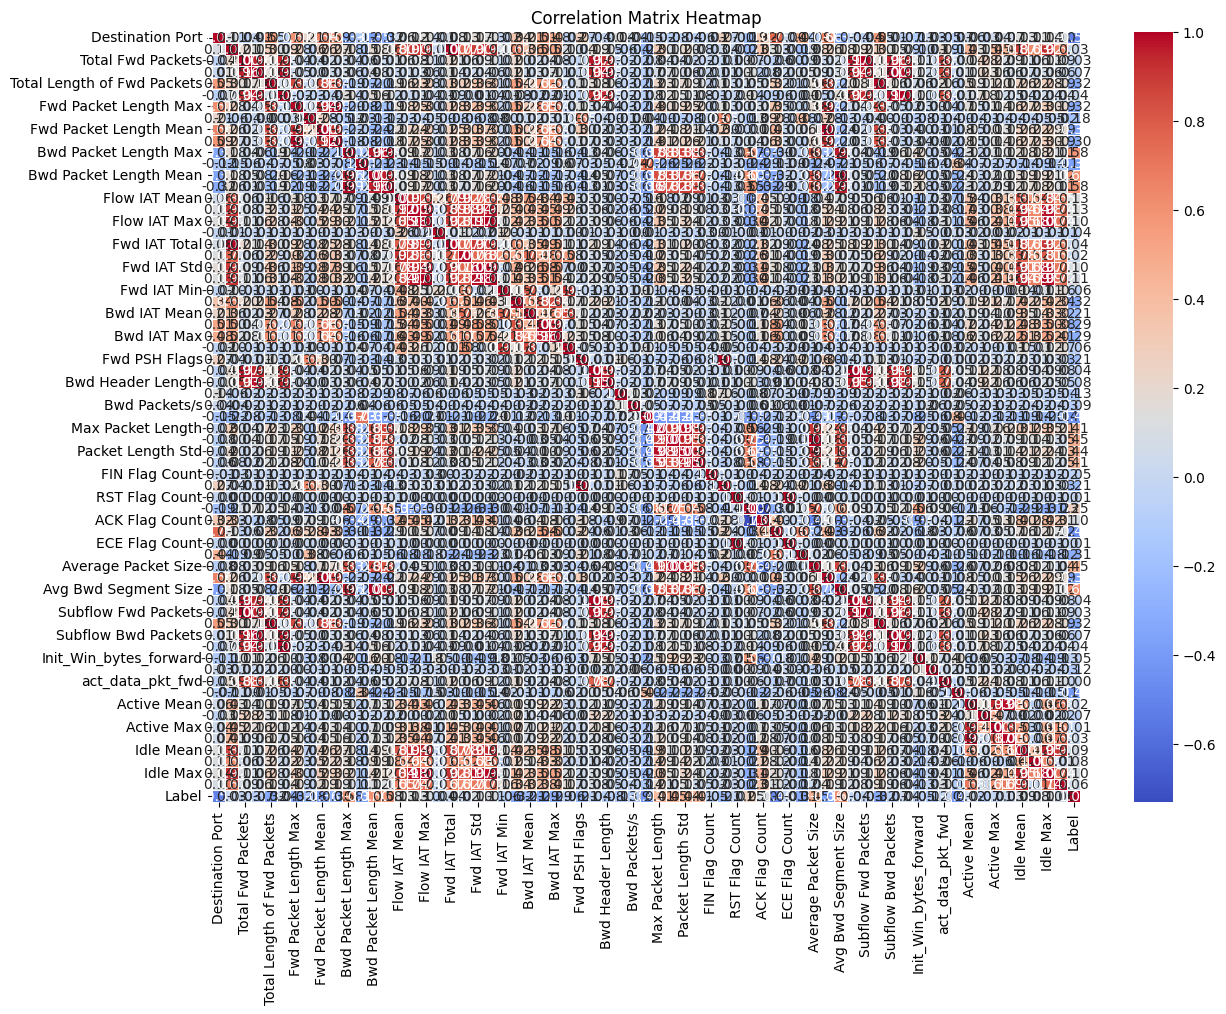

In [456]:
# Compute the correlation matrix
df = df.drop(columns=['Flow Bytes/s', 'Flow Packets/s','Bwd URG Flags','Bwd PSH Flags','Fwd URG Flags','CWE Flag Count','Bwd Avg Bulk Rate','Bwd Avg Bytes/Bulk','Fwd Avg Bytes/Bulk','Fwd Avg Bulk Rate','Bwd Avg Packets/Bulk','Fwd Avg Packets/Bulk'], errors='ignore')
correlation_matrix = df.corr()

# will Plot the heatmap to check for other empty columns etc
plt.figure(figsize=(14, 10))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


No other empty or null columns. so we are good to go. <br>
We can drop more Blue columns but i will keep them for now.

In [437]:
# Redefining X and y as they have changed
X = df.drop(columns=['Label'])
y = df['Label']

### Normalizing data
will use Z-Score Normalization as its best for random forest

In [438]:
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Convert normalized data back to DataFrame
normalized_data = pd.DataFrame(X_normalized, columns=X.columns)
normalized_data['Label'] = y.reset_index(drop=True)

print(normalized_data.head())

   Destination Port  Flow Duration  Total Fwd Packets  Total Backward Packets  Total Length of Fwd Packets  Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  Bwd Packet Length Mean  Bwd Packet Length Std  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  Fwd PSH Flags  Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  Min Packet Length  Max Packet Length  Packet Length Mean  Packet Length Std  Packet Length Variance  FIN Flag Count  SYN Flag Count  RST Flag Count  PSH Flag Count  ACK Flag Count  URG Flag Count  ECE Flag Count  Down/Up Ratio  Average Packet Size  Avg Fwd Segment Size  Avg Bwd Segment Size  Fwd Header Length.1  Subflow Fwd Packets  Subflow Fwd Bytes  Subflow Bwd Packets  Subflow Bwd Bytes  \
0    

### Training the model (Random Forest)

In [439]:
# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(normalized_data.drop(columns=['Label']),normalized_data['Label'],test_size=0.2,random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [440]:
# obv have to check its accuracy
accuracy = rf_classifier.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


A 100% accuracy is usualy a sign of overfitting, which is not good. Ive tried second dataset but the accuracy was still 100% so i will keep it as it is. <br>
Other models like KNN had good accuracy like 94%, 97% etc. But we are told to use this, so ....

In [441]:
# Evaluate the model : Output accuracy, confusion matrix, and classification report
y_pred = rf_classifier.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 1.0
Confusion Matrix:
 [[19219     0]
 [    0 25530]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19219
           1       1.00      1.00      1.00     25530

    accuracy                           1.00     44749
   macro avg       1.00      1.00      1.00     44749
weighted avg       1.00      1.00      1.00     44749



## Hyperparameter tuning

In [442]:
# Defining the model
rf_classifier = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],            #  number of trees
    'max_depth': [None, 10],               #  max depth
    'min_samples_split': [2, 5],           #  min samples split
    'min_samples_leaf': [1, 2],            #  min samples leaf
    'max_features': ['sqrt']               #  max features
}

# Running GridSearchCV 
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# best parameters and best score from GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluating the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Output the confusion matrix and classification report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9998826784431574
Confusion Matrix:
 [[19219     0]
 [    1 25529]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19219
           1       1.00      1.00      1.00     25530

    accuracy                           1.00     44749
   macro avg       1.00      1.00      1.00     44749
weighted avg       1.00      1.00      1.00     44749



In case you are wondring what is : **Hyperparameter tuning** <br>
It exhaustively tests all possible combinations of a predefined set of hyperparameters for a machine learning model to find the combination that yields the best performance according to a chosen evaluation metric.

# testing time

Now, we will use the test data we set aside to manually test the model. 

This is just to simulate a scenario where a user can input their network traffic data into our model to check if it’s normal or indicative of a DDoS attack.

In [448]:
# Load the new CSV data for testing
new_data = pd.read_csv('Test_Fri_Aft_DDOS.csv')


In [449]:
# Preprocess the new data in the same way as the training data
new_data.columns = new_data.columns.str.strip()
new_data['Label'] = new_data['Label'].map({'BENIGN': 0, 'DDoS': 1})
new_data = new_data.drop(columns=['Flow Bytes/s', 'Flow Packets/s','Bwd URG Flags','Bwd PSH Flags','Fwd URG Flags','CWE Flag Count','Bwd Avg Bulk Rate','Bwd Avg Bytes/Bulk','Fwd Avg Bytes/Bulk','Fwd Avg Bulk Rate','Bwd Avg Packets/Bulk','Fwd Avg Packets/Bulk'], errors='ignore')

In [450]:
# Separate features and labels for new data
X_new = new_data.drop(columns=['Label'])
y_new = new_data['Label']

# Ensure the columns in new data match the training data
#  If the columns are not the same, the model will not be able to make predictions
missing_cols = set(X_train.columns) - set(X_new.columns)
if missing_cols:
    print(f"Missing columns in new data: {missing_cols}")
else:
    print("All columns are present.")

All columns are present.


In [ ]:
X_new_normalized = scaler.transform(X_new)

y_pred_new = best_rf.predict(X_new_normalized)
print(f"Accuracy: {accuracy_score(y_new, y_pred_new)}")

# Evaluate the model's performance on new data
print("Confusion Matrix for New Data:")
print(confusion_matrix(y_new, y_pred_new))
print("\nClassification Report for New Data:")
print(classification_report(y_new, y_pred_new))
print("\nAccuracy for New Data:", accuracy_score(y_new, y_pred_new))


Accuracy: 1.0
Confusion Matrix for New Data:
[[ 883    0]
 [   0 1117]]

Classification Report for New Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       883
           1       1.00      1.00      1.00      1117

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Accuracy for New Data: 1.0


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
